In [1]:
from binance.client import Client
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
INPUT_FILE= "API_KEYS.txt"

with open(INPUT_FILE, 'r', encoding='utf-8') as file:
    contenu_liste = file.read()

KEYS = contenu_liste.split(',')
KEYS = [element.strip() for element in KEYS]

api_key = KEYS[0]
api_secret = KEYS[1]
client = Client(api_key,api_secret)

In [39]:
symbol = "BTCUSDT"

In [40]:
# Récupération de la profondeur de marché actuelle
market_depth = client.get_order_book(symbol=symbol)
bids = pd.DataFrame(market_depth['bids'], columns=['price', 'bids'])
asks = pd.DataFrame(market_depth['asks'], columns=['price', 'asks'])
# Conversion en float
bids['price'] = bids['price'].astype(float)
bids['bids'] = bids['bids'].astype(float)
asks['price'] = asks['price'].astype(float)
asks['asks'] = asks['asks'].astype(float)
# Préparer les données pour l'histogramme horizontal
bids['bids_cumsum'] = bids['bids'].cumsum()
asks['asks_cumsum'] = asks['asks'].cumsum()
min_price = min(bids['price'])
max_price = max(asks['price'])

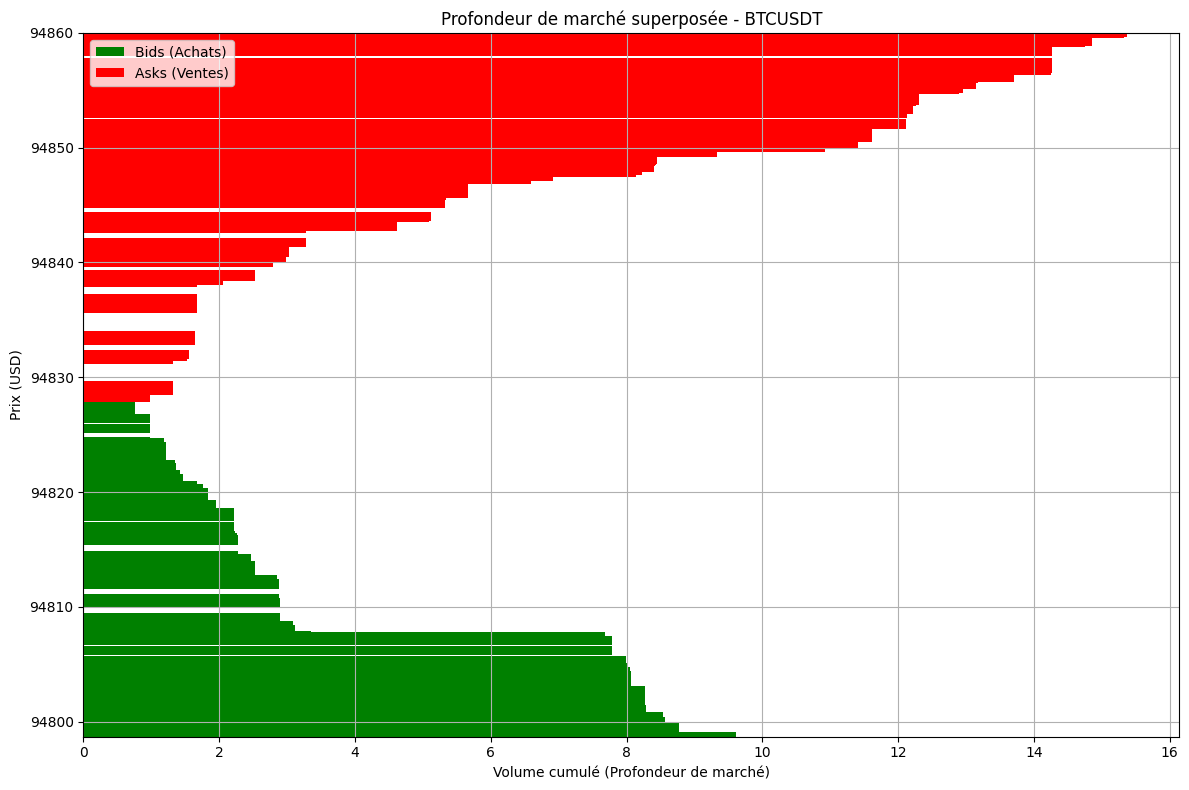

In [41]:
# Création du graphique combiné
fig, ax1 = plt.subplots(figsize=(12, 8))

# Histogramme horizontal (profondeur de marché)
ax1.set_title(f"Profondeur de marché superposée - {symbol}")
ax1.set_ylabel("Prix (USD)")
ax1.barh(bids['price'], bids['bids_cumsum'], color='green', alpha=1, label='Bids (Achats)')
ax1.barh(asks['price'], asks['asks_cumsum'], color='red', alpha=1, label='Asks (Ventes)')
ax1.set_xlabel("Volume cumulé (Profondeur de marché)")
ax1.grid()

# Légendes et ajustements
ax1.legend(loc="upper left")

ax1.set_ylim(min_price, max_price)

plt.tight_layout()
plt.show()